In [2]:
# scikit-image already included in the requirements
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
import os
sys.path.insert(0, os.path.join('..','..','src'))
import numpy as np
import pandas as pd

In [4]:
from utils import kaggle_reader as kr

In [5]:
homepath = os.path.join('..','..')
f = os.path.join(homepath,'data','raw','stage1_train_labels.csv')
decodedlabels = kr.read_kaggle_csv(f)
# load all the images into gray scale
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')
imgDF = kr.load_all_images(impath, mode='RGB')
# find nuclei bounding box information
boxDF = kr.find_mask_bounding_box(decodedlabels, imgDF)

The sizes of nuclei varies a lot. Below is a histogram showing the variation of nuclei sizes.

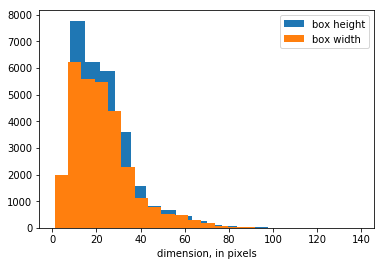

In [6]:
plt.hist(boxDF.boxH, bins=20)
plt.hist(boxDF.boxW, bins=20)
plt.xlabel('dimension, in pixels')
plt.legend(['box height', 'box width'])

In [7]:
boxDF = boxDF.assign(boxHoW = boxDF.boxH/boxDF.boxW)

In [8]:
boxDF[['boxH','boxW', 'boxHoW']].quantile([0.05, 0.1, 0.2, 0.5, 0.9, 0.95])

,boxH,boxW,boxHoW
0.05,7.0,7.0,0.500000
0.10,9.0,9.0,0.618421
0.20,11.0,11.0,0.750000
0.50,20.0,21.0,1.000000
0.90,39.0,40.0,1.555556
0.95,51.0,51.0,1.875000


Proposal: 

Since bounding boxes for most nucleis have a near 1:1 aspect ratio we choose 1:1 as the sliding window aspect ratio. We can set an aspect ratio cutoff to discard very elongated nucleis in the first model. This will simplify the discussion on nuclei sizes to inlcude and sliding window sizes.

In [9]:
# filter out aspect ration less than 0.5 and larger than 2
aspectRatio_filtered_boxDF = boxDF[(boxDF.boxHoW > 0.5) & (boxDF.boxHoW < 2)]
aspectRatio_filtered_boxDF[['boxH', 'boxW']].quantile([0.05, 0.1, 0.2, 0.5, 0.9, 0.95])

,boxH,boxW
0.05,7.0,7.0
0.10,9.0,9.0
0.20,12.0,12.0
0.50,21.0,21.0
0.90,40.0,40.0
0.95,51.0,51.0


Now we can look at the size of the maximum dimension (e.g., for a 1:1 box it is both width and height and for a tall box it is the height) of all the bonding boxes to try to find a good sliding window size

(array([  3.86300000e+03,   6.01000000e+03,   4.89600000e+03,
          4.60900000e+03,   3.45700000e+03,   1.29600000e+03,
          5.33000000e+02,   6.45000000e+02,   6.34000000e+02,
          3.42000000e+02,   1.83000000e+02,   5.30000000e+01,
          1.90000000e+01,   1.00000000e+01,   1.20000000e+01,
          1.00000000e+01,   4.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([   5. ,   11.7,   18.4,   25.1,   31.8,   38.5,   45.2,   51.9,
          58.6,   65.3,   72. ,   78.7,   85.4,   92.1,   98.8,  105.5,
         112.2,  118.9,  125.6,  132.3,  139. ]),
 <a list of 20 Patch objects>)

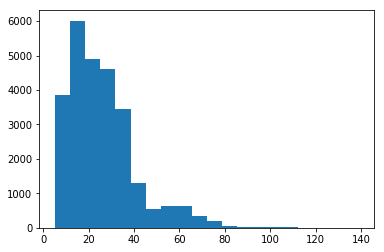

In [10]:
plt.hist(np.amax(aspectRatio_filtered_boxDF[['boxH', 'boxW']], axis=1), bins=20)

In [11]:
np.amax(aspectRatio_filtered_boxDF[['boxH', 'boxW']], axis=1).quantile([0.05, 0.1, 0.2, 0.5, 0.9, 0.95])

0.05     8.0
0.10    10.0
0.20    13.0
0.50    23.0
0.90    44.0
0.95    58.0
dtype: float64

If we want to cover 80% of the nucleis we need to include sizes from 10x10 to 44x44. However, this includes 35 size classes. If we were to choose a window size of 10x10 then we need to downsize the nucleis of size 45x45 more than 20 times and potentially loose a lot of information. One could argue that the losss of information is too much and we ought to choose a larger window size so less compression occurs. If we were to choose a larger window we need to pad the nuclei with smaller dimensions so they can fit the window. Otherwise we would practically give up on training those examples and identify them from test/validation images. 

At the moment the window size is still an open question. We can leave the actual window size open for now and write a script to be able to adapt to different window sizes. We can start with a relatively large window size and discard smaller samples for simplicity. This would produce a reduced training set for us to test algorithms. 

Suppose we were to use window size of 20x20 (the output below shows that equates to about 54% of the total nuclei in the raw training set; also represented by the red dots in the plot below). To preprocess the ROI extractions for training we need to pad the bounding boxes for nucleis and/or resize the extractions to fit into a 20x20 size. We do this in the following steps:
0. find bounding box dimensions boxH, boxW, and aspection ratio boxHoW = boxH/boxW
1. filter out nuclei with boxHoW < 0.5 and boxHoW > 2
2. extract maxdim = max(boxH, boxW) for each box
3. if maxdim < 20, discard image
   if 20 <= maxdim, patch the extraction to size maxdim x maxdim
4. rescale extractions larger than 20x20 to 20x20
This produces ROIs with size 20x20.

In [12]:
aspectRatio_filtered_boxDF = aspectRatio_filtered_boxDF.assign(maxDim = np.amax(aspectRatio_filtered_boxDF[['boxH', 'boxW']], 
                                                                                axis=1))
size_aspectRatio_filtered_boxDF = aspectRatio_filtered_boxDF[aspectRatio_filtered_boxDF.maxDim>=20]
len(size_aspectRatio_filtered_boxDF) / len(boxDF)

0.5420725705169546

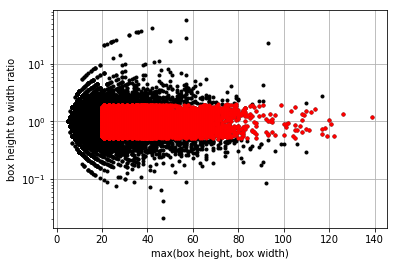

In [13]:
plt.semilogy(np.amax(boxDF[['boxH', 'boxW']], axis=1), boxDF.boxHoW, '.k')
plt.semilogy(np.amax(size_aspectRatio_filtered_boxDF[['boxH', 'boxW']], axis=1), 
             size_aspectRatio_filtered_boxDF.boxHoW, '.r')
plt.xlabel('max(box height, box width)')
plt.ylabel('box height to width ratio')
plt.grid()

In [53]:
from utils import kaggle_io

def scale_all_ROI(root_roi_path, min_box_size, colormode):
    # root_roi_path: path to the root folder containing all ROIs, organized by image 
    # (populated by /data/extract_roi_from_split.py)
    # min_box_size: minimum box size to use, anything smaller is discarded, anything larger is
    # rescaled to match the size
    # colormode: mode to load the image files
    # return: dataframe containing all resized roi image data and associated image ID.
    
    # find the directory names of the images (that contains ROIs)
    imdirs = [d for d in os.listdir(root_roi_path)
              if os.path.isdir(os.path.join(root_roi_path, d))]
    
    imageids = []
    resized_rois = []
    downscale_ratio = []
    original_rois = []
    
    for imdir in imdirs:
        # find all roi image file names under the image folder
        roi_files = [f for f in os.listdir(os.path.join(root_roi_path, imdir))
                    if ('.png' in f)]
        for roi in roi_files:
            roi_image = kaggle_io.png_to_pixel_matrix(os.path.join(root_roi_path, imdir, roi), mode = colormode)
            dimensions = roi_image.shape
            maxdim = max(dimensions[:1])
            if (maxdim < min_box_size) or (dimensions[0] != dimensions[1]):
                # if max dimension of box is smaller than cutoff or box is not squre (means it is on the edge of an image)
                # discard
                continue
            else:
                # otherwise resize the image to the size specificed by min_box_size
                original_rois.append(roi_image)
                roi_resized = resize(roi_image, (maxdim, maxdim), anti_aliasing=True)
                # and save ImageId for the nuclei (may not be necessary) and resized ROI image data
                imageids.append(imdir)
                resized_rois.append(roi_resized)
                downscale_ratio.append(min_box_size / maxdim)

            
    # read the ROI with kaggle_io
    # images = [kaggle_io.png_to_pixel_matrix(os.path.join(roi_path, im, im + '.png'), mode=mode)
    #        for im in imdirs]
    return pd.DataFrame(list(zip(imageids, resized_rois, original_rois, downscale_ratio)), 
                        columns=['ImageId', 'resized_ROI', 'original_ROI', 'downscale_ratio'])
    

In [54]:
roidf = scale_all_ROI('../../data/roi/', 20, 'RGB')

TypeError: resize() got an unexpected keyword argument 'anti_aliasing'

In [39]:
roidf.resized_ROI[0].shape

(20, 20, 3)

In [43]:
maxdownscale_roi = roidf.sort_values('downscale_ratio').iloc[0]

Text(0.5,1,'original')

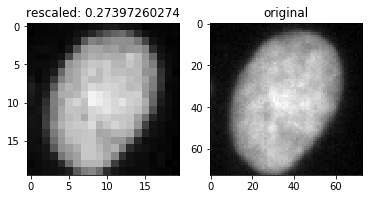

In [48]:
# check the image of the most heavily resized ROI, compared to its original
plt.subplot(1,2,1)
plt.imshow(maxdownscale_roi['resized_ROI'])
plt.title('rescaled: '+str(maxdownscale_roi['downscale_ratio']))
plt.subplot(1,2,2)
plt.imshow(maxdownscale_roi['original_ROI'])
plt.title('original')

In [49]:
roidf = scale_all_ROI('../../data/roi/', 10, 'RGB')

C:\Users\YOUY\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'original')

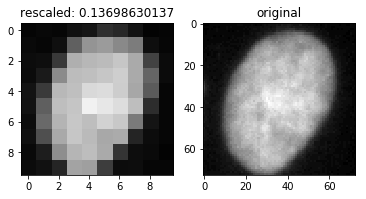

In [50]:
maxdownscale_roi = roidf.sort_values('downscale_ratio').iloc[0]
# check the image of the most heavily resized ROI, compared to its original
plt.subplot(1,2,1)
plt.imshow(maxdownscale_roi['resized_ROI'])
plt.title('rescaled: '+str(maxdownscale_roi['downscale_ratio']))
plt.subplot(1,2,2)
plt.imshow(maxdownscale_roi['original_ROI'])
plt.title('original')

In [55]:
import skimage

In [56]:
skimage.__version__

'0.13.0'